<a href="https://colab.research.google.com/github/FacuBelisario/Tesis-MSE/blob/master/single_axis_control.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sistema de Control de un solo eje

A continuación se presenta un diseño completo de un sistema de control de un solo eje incluyendo un filtro de Kalman para determinación de actitud obtenido del libro **ADCS: Spacecraft Attitude Determination and Control** (Michael Paluszek, Elseiver 2023).

El controlador es configurado como un regulador, por lo que mantiene el ángulo pero no tiene un set point de entrada. El sistema completo se muestra en la siguiente Figura.

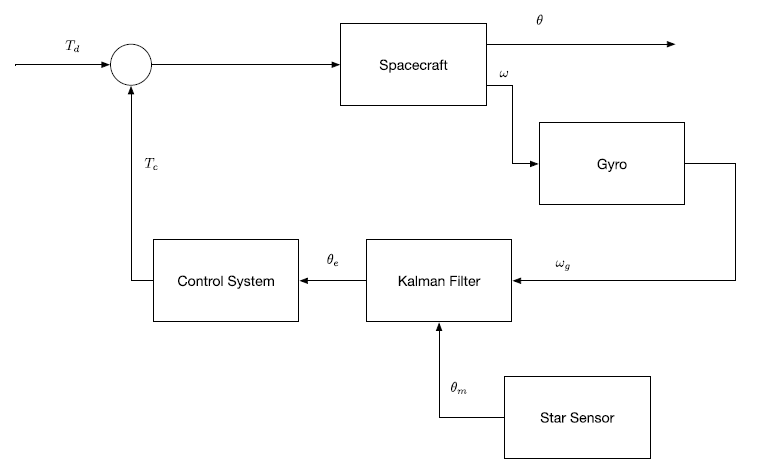

Los dos sistemas dinámicos que necesitan ser modelados en este ejemplo son el satélite y el gyro.

El modelo del satélite es un integrador doble:

$$I \ddot{\theta} = T_{c} + T_{d} $$

ó

$$\dot{\theta} = \omega$$

$$I \dot{\omega} = T_{c} + T_{d}$$

donde $\theta$ es el ángulo real y $\omega$ es la velocidad angular real, $I$ es la inercia, $T_{c}$ es el torque de control y $T_{d}$ es el torque pertubador.

Por otro lado, el modelo del gyro es un integrador simple:

$$\dot{\theta}_{g} = \omega + b + v_{\theta}$$

$$\dot{b} = v_{b}$$

donde $\theta_{g}$ es la integral de la velocidad angular verdadera  $\omega$ más el sesgo $b$. El sesgo se obtiene del ruido blanco, es decir que es un proceso random-walk. $v_{b}$ el la entrada de ruido del sesgo y $v_{\theta}$ es el ruido blanco del ángulo.


# Ejemplo: Simulación de un eje de un satélite con rueda de reacción

El siguiente código corresponde a la obtención de la respuesta del sistema de un solo eje a una entrada escalón  cuando hay un segundo modo. El sistema tiene un modo oscilatorio y un modo de cuerpo rígido.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(0)

In [2]:
# Parámetros del modelo dinámico

tD = 1e-4 # Torque de perturbación en Nm
wJ = 0.6
zetaJ = 0.1
inertiaJ = 0.001
k = inertiaJ * wJ**2
c = 2 * zetaJ * wJ * inertiaJ
dRHS = {
    'inertia': 1,
    'tC': 0,
    'tD': tD,
    'sigTheta': 0.00001,
    'sigB': 0.0001,
    'inertiaJ': inertiaJ,
    'k': k,
    'c': c
}
sigM = 0.01 # Ruido de medición

In [3]:
# %% Diseño del controlador
zeta = 1.0
wN = 0.1
kF = wN**2 * dRHS['inertia']
tauR = 2 * zeta * wN * dRHS['inertia'] / kF
thetaOLD = 0

In [4]:
# %% Cálculo de los valores propios
gamma = dRHS['inertiaJ'] * dRHS['inertia'] / (dRHS['inertiaJ'] + dRHS['inertia'])
a = np.array([
    [0, 0, 1, 0],
    [0, 0, 0, 1],
    [0, dRHS['k'] / dRHS['inertia'], 0, dRHS['c'] / dRHS['inertia']],
    [0, -dRHS['k'] / gamma, 0, -dRHS['c'] / gamma]
])
print("Eigenvalues:", np.linalg.eigvals(a))

Eigenvalues: [ 0.     +0.j          0.     +0.j         -0.06006+0.59728787j
 -0.06006-0.59728787j]


In [5]:
# %% Filtro de Kalman
dT = 0.01
p = np.diag([0.001, 0.0001]) # Covarianza inicial
q = 0.01 * p # Covarianza del modelo
dkF = {
    'p': p,
    'q': q,
    'r': sigM**2,
    'thetaE': 0,
    'xE': np.array([0, 0]),
    'a': np.array([[0, dT], [0, 0]]),
    'b': np.array([dT, 0]),
    'h': np.array([1, 0]),
    'thetaGO1d': 0,
    'dT': dT
}

In [6]:
# %% Configuración de la simulación
n = 1000000
xP = np.zeros((9, n))
x = np.array([0, 0, 0, 0.1, 0, 0]) # [ángulo, velocidad, ángulo del gyro, sesgo, psi, psiDot]

def rhs(x,d):
  omega = x[1]
  b = x[3]
  psi = x[4]
  psiDot = x[5]

  tJ = -d['k'] * psi - d['c'] * psiDot
  omegaDot = (d['tC'] + d['tD'] - tJ) / d['inertia']

  xDot = np.array([
      omega,
      omegaDot,
      omega + b +d['sigTheta'] * np.random.randn(),
      d['sigB'] * np.random.randn(),
      psiDot,
      tJ / d['inertiaJ'] - omegaDot
  ])

  return xDot

def Kalman_filter(thetaG, y, d):
  omega = (thetaG - d['thetaGO1d']) / d['dT']
  d['thetaGO1d'] = thetaG

  # Propagación del estado
  d['xE'] = d['a'].dot(d['xE']) + d['b'] * omega
  d['p'] = d['a'].dot(d['p']).dot(d['a'].T) + d['q']

  # Incorporación de la medición
  k = d['p'].dot(d['h'].T) / (d['h'].dot(d['p']).dot(d['h'].T) + d['r'])
  d['xE'] += k * (y - d['h'].dot(d['xE']))
  d['p'] = (np.eye(2) - np.outer(k, d['h'])).dot(d['p'])
  d['thetaE'] = d['xE'][0]

  return d

def rk4(f, x, dt, params):
  k1 = f(x, params)
  k2 = f(x + 0.5 * dt * k1, params)
  k3 = f(x + 0.5 * dt * k2, params)
  k4 = f(x + dt * k3, params)

  return x + (dt/6) * (k1 + 2 * k2 + 2 * k3 + k4)

for k in range(n):
  thetaM = x[0] + sigM * np.random.randn() # Medición
  thetaG = x[2] # Ángulo del gyro
  dkF = Kalman_filter(thetaG, thetaM, dkF)
  dRHS['tC'] = -kF * (dkF['thetaE'] + tauR * (dkF['thetaE'] - thetaOLD) / dT)
  thetaOLD = dkF['thetaE']
  xP[:, k] = np.concatenate((x, [dRHS['tC'], dkF['thetaE'], thetaM]))
  x = rk4(rhs, x, dT, dRHS)


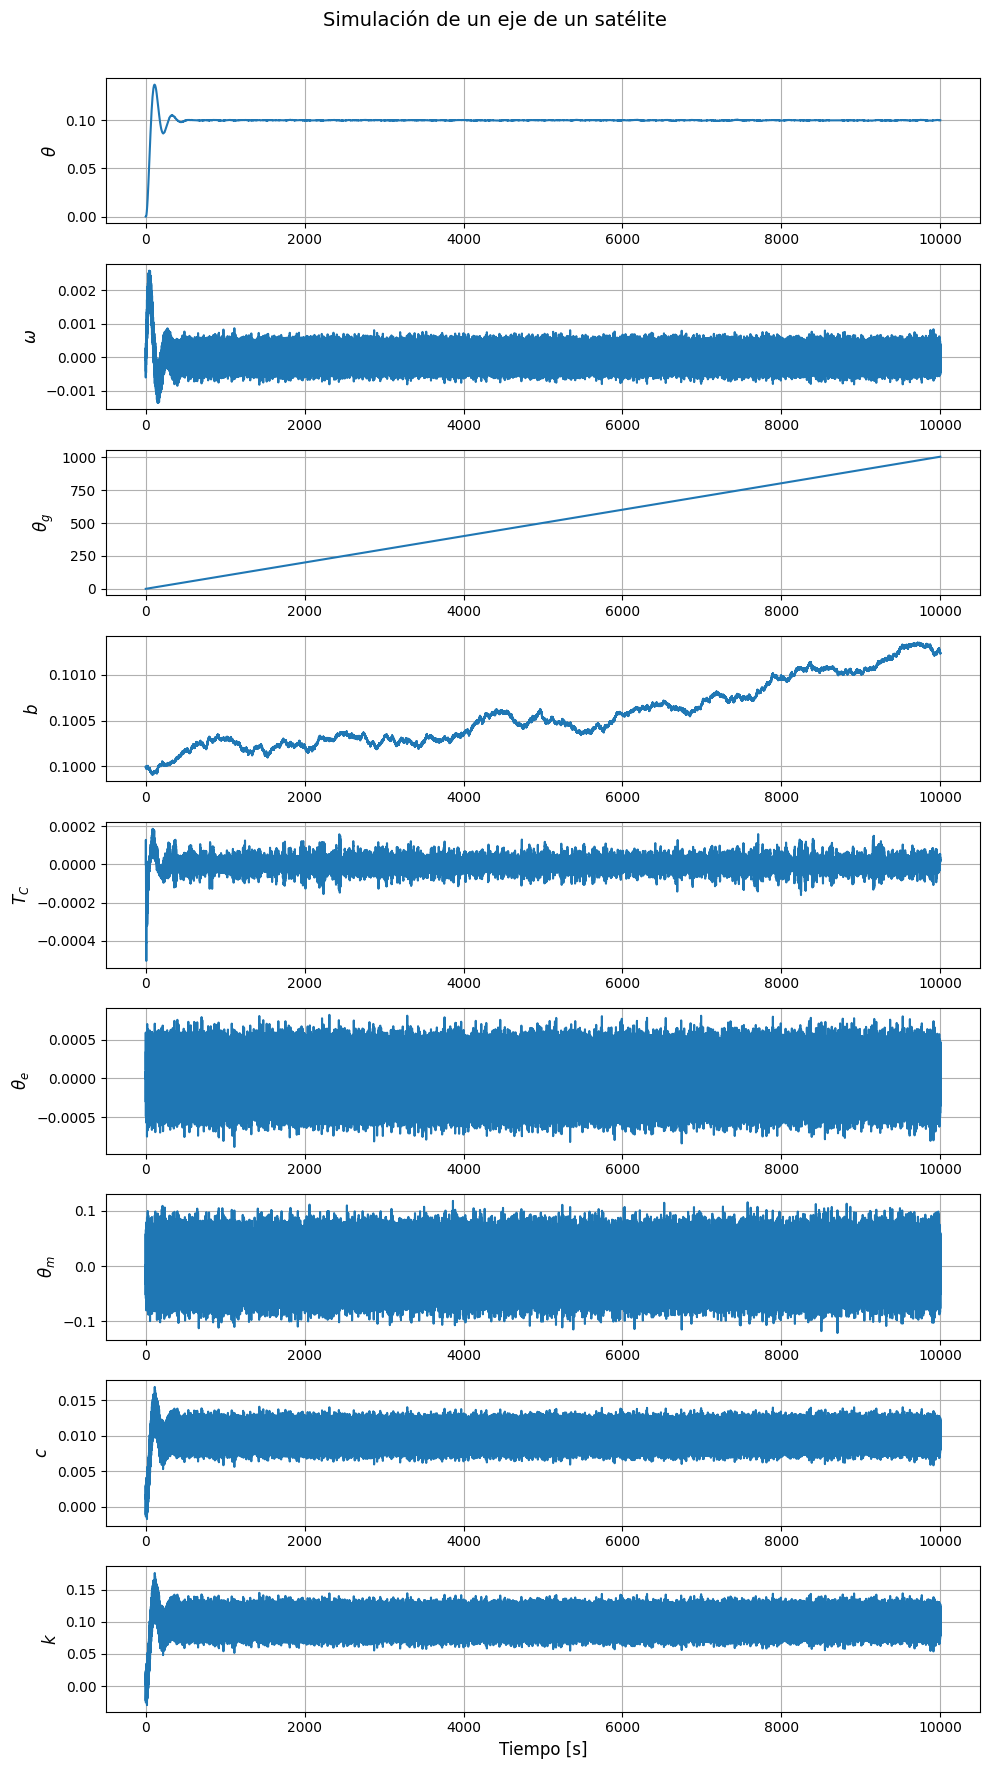

In [7]:
# %% Gráficos
def time_history(t, xP, yL, title_text):
  n_vars = xP.shape[0]
  plt.figure(figsize=(10, 2 * n_vars))
  for i in range(n_vars):
    plt.subplot(n_vars, 1, i + 1)
    plt.plot(t, xP[i, :], linewidth=1.5)
    plt.ylabel(yL[i], fontsize=12)
    plt.grid()
  plt.xlabel('Tiempo [s]', fontsize=12)
  plt.suptitle(title_text, fontsize=14)
  plt.tight_layout(rect=[0, 0, 1, 0.97])
  plt.show()

t = np.arange(0, n * dT, dT)
yL = [
      '$\\theta$', '$\\omega$', '$\\theta_g$', '$b$', '$T_C$',
      '$\\theta_e$', '$\\theta_m$', '$c$', '$k$'
  ]

time_history(t, xP, yL, 'Simulación de un eje de un satélite')